## Cadena de algoritmos y pipeline

Para muchos algoritmos del machine learning, la representación particular de los datos que se proporciona es muy importante. Este proceso comienza con escalar los datos y combinar las funciones a mano y va hasta las características de aprendizaje utilizando el machine learning no supervisado. En consecuencia, la mayoría de las aplicaciones del machine learning  requieren no solo de  la aplicación de un solo algoritmo, sino también de muchos pasos de procesamiento diferentes y modelos de machine learning. Para esto utilizamos `Pipeline` para simplificar el proceso de construcción de cadenas de transformaciones y modelos. En particular,  podemos combinar Pipeline y GridSearchCV para buscar parámetros en todos los pasos de procesamiento al mismo tiempo.

#### Ejemplo

Como ejemplo de la importancia de la cadena de modelos, mejoremos en gran medida el rendimiento de una SVM  en el conjunto de datos de `cancer` mediante el uso de `MinMaxScaler` para el preprocesamiento. Aquí hay un código para dividir los datos, calcular el mínimo y el máximo, escalar los datos y entrenar el SVM:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler

# cargando y dividiendo los datos
cancer = load_breast_cancer()
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    cancer.data, cancer.target, random_state=0)
# calculamos el minimo y  maximo de los datos de entrenamiento
escalador = MinMaxScaler().fit(X_entrenamiento)

# rescalando los datos de entrenamiento
X_entrenamiento_escalado = escalador.transform(X_entrenamiento)

svm = SVC()
# aprender una SVM en los datos de entrenamiento escalados
svm.fit(X_entrenamiento_escalado, y_entrenamiento)

# escalamos los datos de prueba y calificamos los datos escalados
X_prueba_escalado= escalador.transform(X_prueba)
print("Puntuacion del conjunto de datos: {:.2f}".format(svm.score(X_prueba_escalado, y_prueba)))

Puntuacion del conjunto de datos: 0.95


### Selección de paramétros  con preprocesamiento

Ahora digamos que queremos encontrar los  mejores parámetros para SVC usando GridSearchCV. ¿Cómo debemos hacer esto? Un enfoque elemental  podría verse así:

In [2]:
from sklearn.model_selection import GridSearchCV

parametros_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=parametros_grid, cv=5)
grid.fit(X_entrenamiento_escalado, y_entrenamiento)
print("Mejor precision de validacion cruzada: {:.2f}".format(grid.best_score_))
print("Mejores puntajes establecidos: {:.2f}".format(grid.score(X_prueba_escalado, y_prueba)))
print("Mejores parametros: ", grid.best_params_)

Mejor precision de validacion cruzada: 0.98
Mejores puntajes establecidos: 0.97
Mejores parametros:  {'C': 1, 'gamma': 1}


Aquí, ejecutamos la búsqueda de grid sobre los parámetros de SVC usando los datos escalados. Sin embargo, hay una captura sutil en lo que acabamos de hacer. Al escalar los datos, usamos todos los datos en el conjunto de entrenamiento para descubrir cómo entrenarlo. Luego usamos los datos de entrenamiento escalados para ejecutar nuestra búsqueda grid utilizando la validación cruzada.

Para cada división en la validación cruzada, una parte del conjunto de entrenamiento original se declarará como la parte de entrenamiento de la división y parte de la división como conjunto de prueba. La parte de prueba se usa para medir qué datos nuevos que se verán para un modelo entrenado en la parte de entrenamiento. Sin embargo, ya usamos la información contenida en la parte de prueba de la división, al escalar los datos. Se debe recordar que la parte de prueba en cada división en la validación cruzada es parte del conjunto de entrenamiento y usamos la información de todo el conjunto de entrenamiento para encontrar la escala correcta de los datos.

Esto es fundamentalmente diferente de cómo se ven los datos nuevos en el modelo. Si observamos nuevos datos (por ejemplo, en forma de nuestro conjunto de pruebas), estos datos no se habrán utilizado para escalar los datos de entrenamiento y podrían tener un mínimo y un máximo diferentes de los datos de entrenamiento. El siguiente gráfico  muestra cómo el procesamiento de datos durante la validación cruzada y la evaluación final difieren:


In [3]:
def hacer_corchetes(s, xy, textxy, width, ax):
    anotacion = ax.annotate(
        s, xy, textxy, ha="center", va="center", size=20,
        arrowprops=dict(arrowstyle="-[", fc="w", ec="k",
                        lw=2,), bbox=dict(boxstyle="square", fc="w"))
    anotacion.arrow_patch.get_arrowstyle().widthB = width

In [5]:
def dibuja_procesamiento_incorrecto():
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    for axis in axes:
        cajas = axis.barh([0, 0, 0], [11.9, 2.9, 4.9], left=[0, 12, 15],
                         color=['white', 'grey', 'grey'], hatch="//",
                         align='edge', edgecolor='k')
        cajas[2].set_hatch(r"")
        axis.set_yticks(())
        axis.set_frame_on(False)
        axis.set_ylim(-.1, 6)
        axis.set_xlim(-0.1, 20.1)
        axis.set_xticks(())
        axis.tick_params(length=0, labeltop=True, labelbottom=False)
        axis.text(6, -.3, "Grupos de entrenamiento",
                  fontdict={'fontsize': 14}, horizontalalignment="center")
        axis.text(13.5, -.3, "Grupo de validacion",
                  fontdict={'fontsize': 14}, horizontalalignment="center")
        axis.text(17.5, -.3, "Conjunto de pruebas",
                  fontdict={'fontsize': 14}, horizontalalignment="center")

    hacer_corchetes("Ajuste escalador", (7.5, 1.3), (7.5, 2.), 15, axes[0])
    hacer_corchetes("Ajuste SVC", (6, 3), (6, 4), 12, axes[0])
    hacer_corchetes("Prediccion SVC", (13.4, 3), (13.4, 4), 2.5, axes[0])

    axes[0].set_title("Validacion cruzada")
    axes[1].set_title("Prediccion del conjunto de prueba")

    hacer_corchetes("Ajuste escalador", (7.5, 1.3), (7.5, 2.), 15, axes[1])
    hacer_corchetes("Ajuste SVC", (7.5, 3), (7.5, 4), 15, axes[1])
    hacer_corchetes("Prediccion SVC", (17.5, 3), (17.5, 4), 4.8, axes[1])

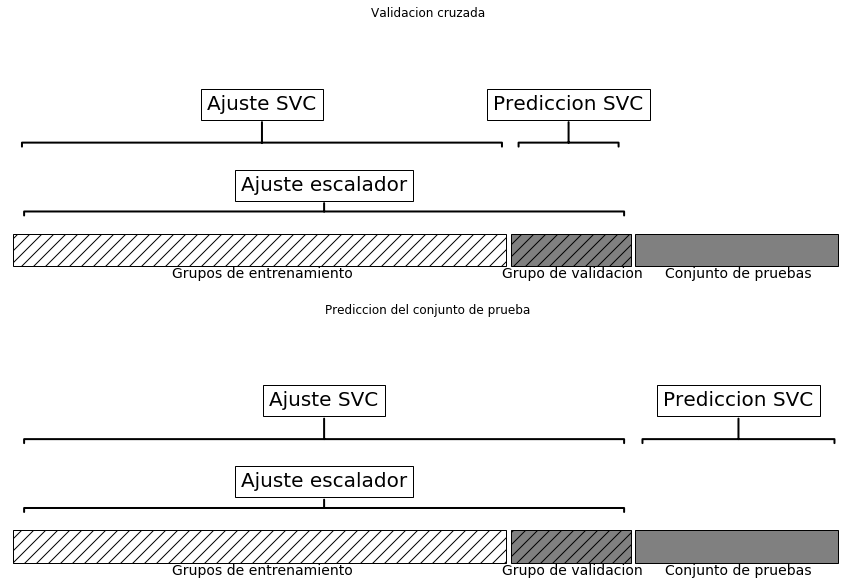

In [6]:
dibuja_procesamiento_incorrecto()

Por lo tanto, las divisiones en la validación cruzada ya no reflejan correctamente cómo se verán los datos nuevos en el proceso de modelado. Ya filtramos información de estas partes de los datos en nuestro proceso de modelado. Esto conducirá a resultados excesivamente optimistas durante la validación cruzada y posiblemente a la selección de parámetros subóptimos.

Para evitar este problema, la división del conjunto de datos durante la validación cruzada debe realizarse antes de realizar cualquier preprocesamiento. Cualquier proceso que extraiga conocimiento del conjunto de datos solo debe aplicarse a la parte de entrenamiento del conjunto de datos, por lo que cualquier validación cruzada debe ser el "bucle más externo" en el procesamiento.

Para lograr esto en scikit-learn con la función `cross_val_score` y la función `Grid SearchCV`, podemos usar la clase `Pipeline`. La clase Pipeline es una clase que permite "pegar" varios pasos de procesamiento en un único estimador scikit-learn. La clase Pipeline tiene los métodos `fit`, `predict` y `score ` y se comporta como cualquier otro modelo en scikit-learn. El caso de uso más común de la clase Pipeline es encadenar los pasos de preprocesamiento (como el escalado de los datos) junto con un modelo supervisado como un clasificador.

### Construcción de tuberías

Veamos cómo podemos usar la clase Pipeline para expresar el flujo de trabajo para entrenar un SVM después de escalar los datos con MinMaxScaler (por ahora sin la búsqueda grid). En primer lugar, construimos un objeto pipeline proporcionándole una lista de pasos. Cada paso es una tupla que contiene un nombre (cualquier cadena de su elección) y una instancia de un estimador:

In [7]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("escalador", MinMaxScaler()), ("svm", SVC())])

Aquí, creamos dos pasos: el primero, llamado "escalador", una instancia de MinMaxScaler, y el segundo, llamado "svm",  una instancia de SVC. Ahora, podemos ajustar el pipeline, como cualquier otro estimador scikit-learn:

In [8]:
pipe.fit(X_entrenamiento, y_entrenamiento)

Pipeline(memory=None,
     steps=[('escalador', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Aquí, las primeras llamadas de pipe.fit encajan en el primer paso (el escalador), luego transforma los datos de entrenamiento utilizando el escalador y finalmente ajusta el SVM con los datos escalados. Para evaluar los datos de prueba, simplemente llamamos pipe.score:

In [9]:
print("Puntuacion del conjunto de pruebas: {:.2f}".format(pipe.score(X_prueba, y_prueba)))

Puntuacion del conjunto de pruebas: 0.95


Llamar primero al método `score` en el objeto pipeline,  transforma los datos de prueba usando el escalador, y luego llama al método `score `en SVM utilizando los datos de prueba a escala. Como se puede ver, el resultado es idéntico al que obtuvimos del código al comienzo, al realizar las transformaciones a mano. Al usar pipeline, redujimos el código necesario para nuestro proceso de "preprocesamiento + clasificación". Sin embargo, el principal beneficio de utilizar pipeline es que ahora podemos usar este único estimador en `cross_val_score` o `GridSearchCV`.

### Uso de pipeline en búsquedas grid

Usar pipeline en una búsqueda grid funciona de la misma manera que usar cualquier otro estimador. Definimos una  parámetros grid para buscar y construir un GridSearchCV desde el pipeline  y los parámetros grid. Sin embargo, cuando se especifica los paramétros grid, hay un ligero cambio. Necesitamos especificar para cada parámetro a qué paso del pipeline pertenece. Ambos parámetros que queremos ajustar, C y gamma, son parámetros de SVC, el segundo paso (le dimos a este paso el nombre "svm").

La sintaxis para definir paramétros grid para un pileline es especificar para cada parámetro el nombre del paso, seguido de `__ `(un guion bajo doble), seguido por el nombre del parámetro. Para buscar usar el parámetro C de SVC, por lo tanto, debemos escribir `svm__C` como la clave en el diccionario de parámetros grid  y de manera similar para gamma:


In [10]:
parametros_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                   'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

Con este parametros grid podemos usar GridSearchCV como de costumbre:


In [11]:
grid = GridSearchCV(pipe, param_grid=parametros_grid, cv=5)
grid.fit(X_entrenamiento, y_entrenamiento)
print("Mejor precision de validacion cruzada {:.2f}".format(grid.best_score_))
print("Puntuacion de conjunto de prueba {:.2f}".format(grid.score(X_prueba, y_prueba)))
print("Mejores parametros: {}".format(grid.best_params_))

Mejor precision de validacion cruzada 0.98
Puntuacion de conjunto de prueba 0.97
Mejores parametros: {'svm__C': 1, 'svm__gamma': 1}


A diferencia de la búsqueda grid que hicimos antes, ahora para cada división en la validación cruzada, el MinMaxScaler se reajusta solo con las divisiones de entrenamiento y no se filtra información de la división de prueba en la búsqueda de parámetros. Compare esta figura con la figura anterior en este cuaderno:

In [12]:
def dibuja_procesamiento_correcto():
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    for axis in axes:
        cajas = axis.barh([0, 0, 0], [11.9, 2.9, 4.9], left=[0, 12, 15],
                         color=['white', 'grey', 'grey'], hatch="//",
                         align='edge', edgecolor='k')
        cajas[2].set_hatch(r"")
        axis.set_yticks(())
        axis.set_frame_on(False)
        axis.set_ylim(-.1, 4.5)
        axis.set_xlim(-0.1, 20.1)
        axis.set_xticks(())
        axis.tick_params(length=0, labeltop=True, labelbottom=False)
        axis.text(6, -.3, "Grupos de entrenamiento",
                  fontdict={'fontsize': 14}, horizontalalignment="center")
        axis.text(13.5, -.3, "Grupo de validacion",
                  fontdict={'fontsize': 14}, horizontalalignment="center")
        axis.text(17.5, -.3, "Conjunto de pruebas",
                  fontdict={'fontsize': 14}, horizontalalignment="center")

    hacer_corchetes("Ajuste escalador", (6, 1.3), (6, 2.), 12, axes[0])
    hacer_corchetes("Ajuste SVC", (6, 3), (6, 4), 12, axes[0])
    hacer_corchetes("Prediccion SVC", (13.4, 3), (13.4, 4), 2.5, axes[0])

    axes[0].set_title("Validacion cruzada")
    axes[1].set_title("Prediccion del conjunto de prueba")

    hacer_corchetes("Ajuste escalador", (7.5, 1.3), (7.5, 2.), 15, axes[1])
    hacer_corchetes("Ajuste SVC", (7.5, 3), (7.5, 4), 15, axes[1])
    hacer_corchetes("Prediccion SVC", (17.5, 3), (17.5, 4), 4.8, axes[1])
    fig.subplots_adjust(hspace=.3)

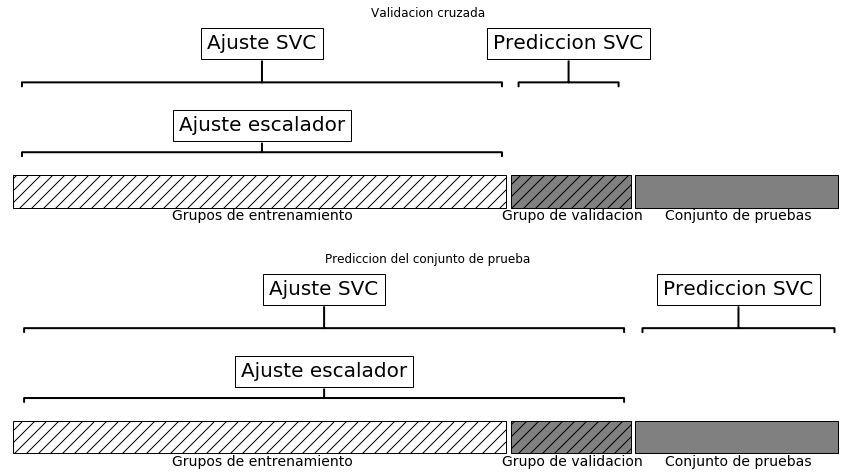

In [14]:
dibuja_procesamiento_correcto()

El impacto de la información filtrada en la validación cruzada varía según la naturaleza del paso de preproceso. Estimar la escala de los datos utilizando el grupo  de prueba generalmente no tiene un impacto terrible, mientras que usar el grupo de prueba en la extracción de características y la selección de características puede llevar a diferencias sustanciales en los resultados.

### Ilustrando información filtrada

Un buen ejemplo de información filtrada en validación cruzada se encuentra en Hastie, Tibshirani y en el libro de Friedman, The Elements of Statistical Learning y reproducimos una versión adaptada aquí. Consideremos una tarea de regresión artificial con 100 muestras y 1,000 características que se muestrean independientemente de una distribución gaussiana. También probamos la respuesta de una distribución Gaussiana:


In [15]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

Dada la forma en que creamos el conjunto de datos, no hay relación entre los datos, X y el objetivo, y (son independientes), por lo que no debería ser posible aprender nada de este conjunto de datos. Ahora haremos lo siguiente. Primero, seleccionamos la más informativa de las 10 características usando la selección de características `SelectPercentile` y luego evaluamos un regresor Ridge usando la validación cruzada:

In [17]:
from sklearn.feature_selection import SelectPercentile, f_regression

selecciona_caracteristica = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_seleccionado= selecciona_caracteristica.transform(X)
print("Dimension del X_seleccionado: {}".format(X_seleccionado.shape))

Dimension del X_seleccionado: (100, 500)


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Precision de la validacion cruzada (cv en ridge): {:.2f}".format(
    np.mean(cross_val_score(Ridge(), X_seleccionado, y, cv=5))))

Precision de la validacion cruzada (cv en ridge): 0.91


La $R^2$ media calculada por validación cruzada es 0,91, lo que indica un modelo muy bueno. Esto claramente no puede ser correcto, ya que nuestros datos son completamente aleatorios. Lo que sucedió aquí es que nuestra selección de características seleccionó algunas características entre las 10,000 características aleatorias que (casualmente) están muy correlacionadas con el objetivo.

Debido a que ajustamos la selección de características fuera de la validación cruzada, podría encontrar características correlacionadas tanto en el entrenamiento como en los grupos de prueba. La información que filtramos de los grupos de prueba fue muy informativa, lo que generó resultados muy poco realistas. Comparemos esto con una validación cruzada apropiada usando un pipeline:

In [19]:
pipe = Pipeline([("selecciona_caracteristica", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
print("Precision de la validacion cruzada (pipeline): {:.2f}".format(
    np.mean(cross_val_score(pipe, X, y, cv=5))))

Precision de la validacion cruzada (pipeline): -0.25


Esta vez, obtenemos un puntaje $R^2$ negativo, lo que indica un modelo muy pobre. Con pipeline, la selección de características se encuentra ahora dentro del ciclo de validación cruzada. Esto significa que las características solo pueden seleccionarse utilizando los grupos de entrenamiento de los datos, no el grupo de prueba. La selección de características encuentra características que están correlacionadas con el objetivo en el conjunto de entrenamiento, pero debido a que los datos son completamente aleatorios, estas características no están correlacionadas con el objetivo en el conjunto de prueba.

En este ejemplo, rectificar el problema de filtración de datos en la selección de características hace la diferencia entre concluir que un modelo funciona muy bien y concluir que un modelo no funciona en absoluto.